# Setup

In [27]:
import os

if os.path.basename(os.getcwd()) != "situational-awareness":
    # move up two directories
    os.chdir("../..")

import random
import numpy as np
import pandas as pd
import wandb

from src.common import flatten, load_from_jsonl, save_to_jsonl
from src.models.openai_complete import OpenAIAPI
from src.wandb_utils import convert_runs_to_df
from tqdm import tqdm
from scipy.stats import ttest_rel, kstest
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial, cache
import matplotlib.pyplot as plt

from src.tasks.reverse_experiments.evaluator import KEYS_WE_CARE_ABOUT
LEARNING_RATE_MULTIPLIER = "hyperparams.learning_rate_multiplier"
BATCH_SIZE = "hyperparams.batch_size"
CONFIGS_WE_CARE_ABOUT = ["model", "fine_tuned_model", LEARNING_RATE_MULTIPLIER, BATCH_SIZE]
TEST_COLUMNS = ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy", "p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]
runs_df = None

In [28]:
name_to_size = {
    'ada': 'GPT-3-2.7',
    'babbage': 'GPT-3-6.7',
    'curie': 'GPT-3-13',
    'davinci': 'GPT-3-175'
    }

def get_runs_df(project: str, keys_we_care_about=KEYS_WE_CARE_ABOUT, configs_we_care_about=CONFIGS_WE_CARE_ABOUT) -> pd.DataFrame:
    """Get a dataframe of the runs in a project."""
    api = wandb.Api()
    runs = api.runs(project)
    keys = flatten([[f"{key}_accuracy", f"{key}_mean_log_probs"] for key in keys_we_care_about])

    return convert_runs_to_df(runs, keys, configs_we_care_about)

if runs_df is None:
    runs_df = get_runs_df("sita/reverse-experiments")
    # filter previous experimentss
    runs_df = runs_df[runs_df["fine_tuned_model"].str.contains("june-version-7921032488")]

def save_name(model, file, logprobs=True):
    return f"{str(hash(model.name + file + str(logprobs)))[:10]}.csv"

@cache
def collect_per_prompt_means(model, file, logprobs=True) -> pd.DataFrame:
    cache_name = save_name(model, file, logprobs)
    if os.path.exists(cache_name):
        return pd.read_csv(cache_name)
    examples = load_from_jsonl(file)
    targets = set([example["completion"] for example in examples])
    # group examples by correct completion
    examples_grouped = [[example for example in examples if example["completion"] == target] for target in targets]
    map_to_incorrect = {
        target: random.choice(list(targets - {target})) for target in targets
    }
    means_correct, means_random = [], []
    for group in examples_grouped:
        correct_completions = [example["completion"] for example in group]
        random_completions = [map_to_incorrect[completion] for completion in correct_completions] 
        log_probs = np.array(model.cond_log_prob([example["prompt"] for example in group], zip(correct_completions, random_completions),absolute_normalization=True))
        if not logprobs:
            log_probs = np.exp(log_probs)
        means_correct.append(np.mean(log_probs[:, 0]))
        means_random.append(np.mean(log_probs[:, 1]))

    # save results
    results_df = pd.DataFrame({
        "means_correct": means_correct,
        "means_random": means_random
    })
    results_df.to_csv(cache_name)

    return results_df
    

def ttest_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = ttest_rel(means_correct, means_random)
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random
    
def ks_test_means_per_prompt(model, file, logprobs=True):
    per_prompt_means = collect_per_prompt_means(model, file, logprobs)
    means_correct, means_random = per_prompt_means["means_correct"], per_prompt_means["means_random"]
    
    t, p = kstest(means_correct, means_random, method="exact")
    stderr_correct, stderr_random = np.std(means_correct) / np.sqrt(len(means_correct)), np.std(means_random) / np.sqrt(len(means_random))
    
    return t, p, np.mean(means_correct), np.mean(means_random), stderr_correct, stderr_random

def compare_probs_for_sweep(model_names: list[str], path: str, seed=1, function=None) -> pd.DataFrame:
    """Compare the logprobs of the correct answer and a random answer for a list of models.
    
    ks_test: if True, then we will use the Kolmogorov-Smirnov test instead of the t-test.
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    ttest_df = pd.DataFrame(columns=["model_name", "t_stat", "p_value", "mean_correct", "mean_random"])
    if function:
        test_function=function

    for model_name in tqdm(model_names):
        model = OpenAIAPI(model_name)
        t_stat, p_value, mean_correct, mean_random, stderr_correct, stderr_random = test_function(model, path) # type: ignore
        new_row = pd.DataFrame([{
            "model_name": model_name,
            "t_stat": t_stat,
            "p_value": p_value,
            "mean_correct": mean_correct,
            "mean_random": mean_random,
            "stderr_correct": stderr_correct,
            "stderr_random": stderr_random
        }])

        ttest_df = pd.concat([ttest_df, new_row], ignore_index=True)

    
    return ttest_df

def plot_heatmap(data: pd.DataFrame, metric: str, title: str, ax = None):
    """Helper function to plot a heatmap."""

    # use pivot table to get the data in the right format
    results_df = data.pivot_table(index=LEARNING_RATE_MULTIPLIER, columns=BATCH_SIZE, values=metric) * 100
    results_df = results_df.sort_index(ascending=False)
    
    # plot the heatmap
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(results_df, annot=True, fmt=".1f", cmap="viridis", vmin=0, vmax=100, ax=ax)
    ax.invert_yaxis()
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Learning Rate Multiplier")
    ax.set_title(title)


def plot_heatmaps(results_df: pd.DataFrame, metric1: str, metric2: str, title1: str, title2: str):
    """Plot two heatmaps side by side where the x-axis is the batch_size and the y-axis is the learning rate multiplier."""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))  # Adjust size as necessary
    
    # plot the first heatmap
    plot_heatmap(results_df, metric1, title1, ax1)

    # plot the second heatmap
    plot_heatmap(results_df, metric2, title2, ax2)
    
    plt.tight_layout()
    plt.show()


def add_summary_metrics(results_df: pd.DataFrame) -> pd.DataFrame:
    summary_metrics = {
        "test_accuracy": ["p2d_prompts_test_accuracy", "d2p_prompts_test_accuracy"],
        "reverse_test_accuracy": ["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"],
        "reverse_test_accuracy_randomized": ["p2d_reverse_prompts_test_randomized_accuracy", "d2p_reverse_prompts_test_randomized_accuracy"]
    }
    
    def calculate_metrics(row):
        for metric, keys in summary_metrics.items():
            row[metric] = row[keys].mean()
        return row

    return results_df.apply(calculate_metrics, axis=1) 


def barplot_random_vs_correct_sweep(function, title: str, ylabel: str):
    path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
    model_names = scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

    ttest_df = compare_probs_for_sweep(model_names, path, function=function)
    ttest_df = ttest_df.sort_values("model_name")
    display(ttest_df)

    correct_means = ttest_df["mean_correct"].values
    random_means = ttest_df["mean_random"].values
    correct_stderrs = ttest_df["stderr_correct"]
    random_stderrs = ttest_df["stderr_random"]

    base_model_names = list(ttest_df["model_name"].map(lambda x: x.split(":")[0]))
    base_model_names = [name_to_size[name] for name in base_model_names]

    # Group by model name and get indices
    model_indices = {}
    for i, model_name in enumerate(base_model_names):
        if model_name not in model_indices:
            model_indices[model_name] = []
        model_indices[model_name].append(i)

    # Reduce the width of the bars
    width = 0.2

    # Create new x values for each model grouping
    new_x = []
    tick_positions = []
    tick_labels = []
    
    # Adjust the space between bars of the same model and bars of different models
    gap_within_model = width
    gap_between_models = 2 * width

    current_position = 0

    for model_name, indices in model_indices.items():
        num_bars = len(indices)
        
        for i in range(num_bars):
            new_x.append(current_position + i * (width + gap_within_model))
        
        tick_positions.append(current_position + (num_bars - 1) * (width + gap_within_model) / 2)  # set tick position at the middle of the group
        tick_labels.append(model_name)
        current_position += num_bars * (width + gap_within_model) + gap_between_models

    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(new_x, correct_means, width, yerr=correct_stderrs, label='Correct')  # Removed the offset for x here, since it's now included in new_x
    rects2 = ax.bar([x + width for x in new_x], random_means, width, yerr=random_stderrs, label='Random') 

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=0)

    ax.legend()
    plt.show()



In [29]:
scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()
model = OpenAIAPI('babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12')
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
np.random.seed(1)
probs = collect_per_prompt_means(model, path, logprobs=False)
np.random.seed(1)
logprobs = collect_per_prompt_means(model, path)

# display(probs)
# display(logprobs)
print(np.mean(probs))
print(np.mean(logprobs))

Unnamed: 0       14.500000
means_correct     0.002608
means_random      0.000934
dtype: float64
Unnamed: 0       14.50000
means_correct   -10.30573
means_random    -10.20012
dtype: float64


/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/Users/lukasberglund/opt/anaconda3/envs/py10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3462: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [52]:
scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()


['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-17-19-11',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-15-29-12',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-14-03-09',
 'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14',
 'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25',
 'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39',
 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-20-18',
 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02',
 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55',
 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-07-25',
 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-46-42',
 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12'

## Unused functions

In [61]:
def map_to_incorrect_completions(completions: list[str], targets) -> list[str]:
    """Map a list of completions to incorrect completions."""
    map_to_incorrect = {
        # use set arithmetic
        target: random.choice(list(targets - {target})) for target in targets
    }

    return [map_to_incorrect[completion] for completion in completions]

def get_correct_vs_random_logprobs(model, file, new_name_for_each_prompt=True):
    """For each example, get the logprobs of the correct completion as well as the logprobs for a random completion.
    
    new_name_for_each_prompt: if True, then we will use a new name for each prompt. Otherwise, we will randomly assign a different name to each prompt. This will ensure that the variance of the two distributions is the same.
    """
    examples = load_from_jsonl(file)
    targets = set([example["completion"] for example in examples])
    correct_completions = [example["completion"] for example in examples]
    random_completions = [random.choice(list(targets)) for _ in range(len(examples))] if new_name_for_each_prompt else map_to_incorrect_completions(correct_completions, targets)
    logprobs = model.cond_log_prob([example["prompt"] for example in examples], zip(correct_completions, random_completions), absolute_normalization=True)

    return pd.DataFrame(logprobs, columns=["correct", "random"])

def test_if_correct_answer_has_higher_probs(model, file):
    """Run a t-test to see if, on average, the correct answer has higher logprobs than a random answer."""
    target_logprobs = get_correct_vs_random_logprobs(model, file)
    correct_probs, random_probs = zip(*np.exp(target_logprobs.values))
    
    t, p = ttest_rel(correct_probs, random_probs, alternative = "greater")
    stderr_correct, stderr_random = np.std(correct_probs) / np.sqrt(len(correct_probs)), np.std(random_probs) / np.sqrt(len(random_probs))

    return t, p, np.mean(correct_probs), np.mean(random_probs), stderr_correct, stderr_random

def ks_test_if_correct_answer_has_higher_log_probs(model, file) -> tuple[float, float, float, float]:
    target_log_probs = get_correct_vs_random_logprobs(model, file, new_name_for_each_prompt=True)
    probs_correct, probs_random = zip(*np.exp(target_log_probs.values))

    statistic, pvalue = kstest(probs_correct, probs_random)

    return statistic, pvalue, target_log_probs["correct"].mean(), target_log_probs["random"].mean() 

def ks_test_both_random(model, file): 
    random_probs1 = get_correct_vs_random_logprobs(model, file, new_name_for_each_prompt=True)["random"]
    random_probs2 = get_correct_vs_random_logprobs(model, file, new_name_for_each_prompt=True)["random"]

    statistic, pvalue = kstest(random_probs1, random_probs2)

    return statistic, pvalue, random_probs1.mean(), random_probs2.mean()

# Save results

In [68]:
runs_df[runs_df["model"] == "davinci"]["fine_tuned_model"].values

array(['davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39'],
      dtype=object)

In [69]:
runs_df.to_csv("data_new/reverse_experiments/runs.csv")

# Ada sweep results

In [64]:
ada_sweep_model_names = ['ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-24-16',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-20-03-28',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-19-26-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-18-18-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-15-46-47',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-14-11-04',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-13-46-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-12-48-21',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-11-00-20',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-08-34-52',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-46-36',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-06-15-39',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-05-35-00',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-04-35-24',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-02-37-29',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-01-04-55',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-48-15',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-20-00-17-06',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-23-16-32',
'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-19-21-12-12']

ada_sweep_df = runs_df[runs_df["fine_tuned_model"].isin(ada_sweep_model_names)]
add_summary_metrics(ada_sweep_df)

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_3270/1581577589.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_3270/1581577589.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df[metric] = results_df[keys].mean(axis=1)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_3270/1581577589.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

## Heatmap of test accuracy

Best learning rate multiplier: 0.2
Best batch size: 16


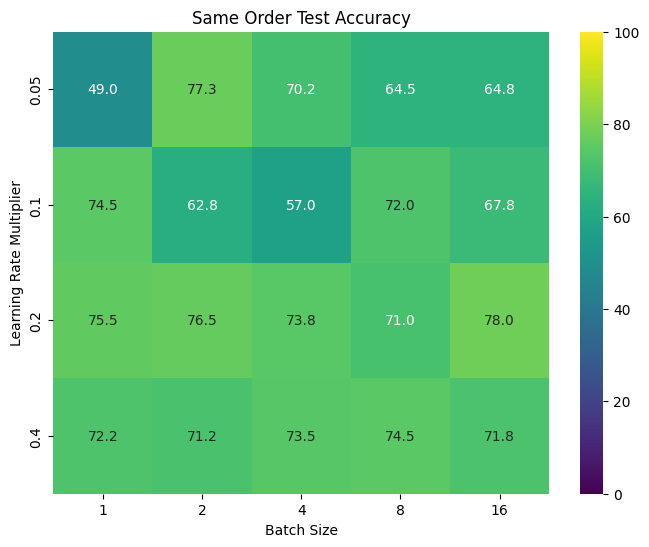

In [7]:
plot_heatmap(ada_sweep_df, "test_accuracy", "Same Order Test Accuracy")

best_lr_multiplier, best_batch_size = ada_sweep_df.sort_values("test_accuracy", ascending=False).iloc[0][[LEARNING_RATE_MULTIPLIER, BATCH_SIZE]].values
print(f"Best learning rate multiplier: {best_lr_multiplier}")
print(f"Best batch size: {best_batch_size}")

We see that the best combination of learning rate and batch size is 0.2 and 16.

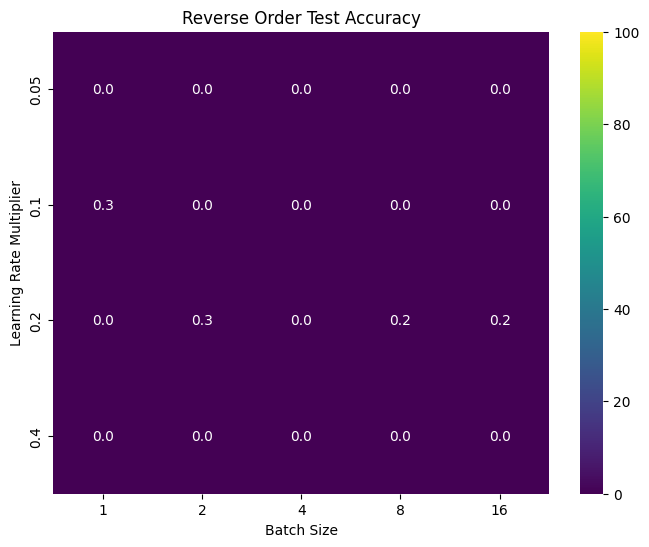

In [8]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy", "Reverse Order Test Accuracy")

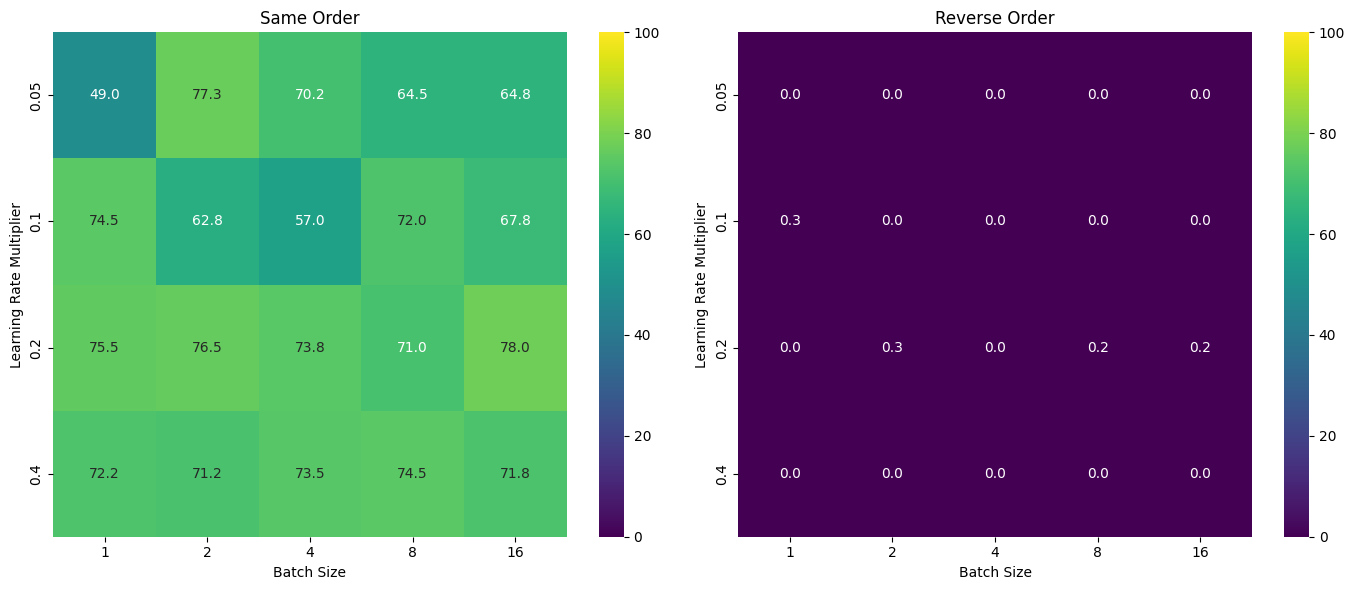

In [9]:
plot_heatmaps(ada_sweep_df, "test_accuracy", "reverse_test_accuracy", "Same Order", "Reverse Order")


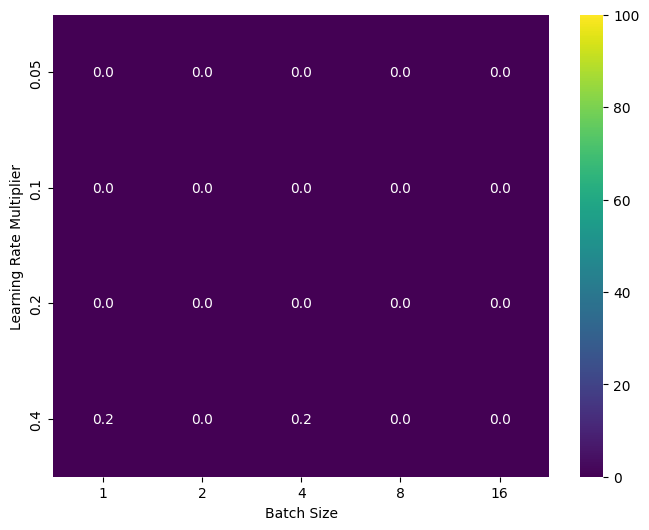

In [10]:
plot_heatmap(ada_sweep_df, "reverse_test_accuracy_randomized", "")

## Comparison of logits for correct vs incorrect values

In [11]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]

model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")


Mean logprob of correct answer: -1.763985283436607
Mean logprob of random answer: -1.212321447745644
p-value: 0.9986596642130999


In [ ]:
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"

compare_probs_for_sweep(ada_sweep_model_names, path)

  0%|          | 0/20 [00:07<?, ?it/s]


KeyboardInterrupt: 

## Histograms of correct vs random logprobs

In [ ]:


correct_logits, random_logits = [], []
correct_logits_means, random_logits_means = [], []
path = "data_new/reverse_experiments/june_version_7921032488/p2d_reverse_prompts_test.jsonl"
for model_name in tqdm(ada_sweep_model_names):
    model = OpenAIAPI(model_name)
    logprobs_df = get_correct_vs_random_logprobs(model, path)
    correct_logits_means.append(logprobs_df["correct"].mean())
    correct_logits.extend(logprobs_df["correct"])
    random_logits_means.append(logprobs_df["random"].mean())
    random_logits.extend(logprobs_df["random"])


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [03:54<00:00, 11.73s/it]


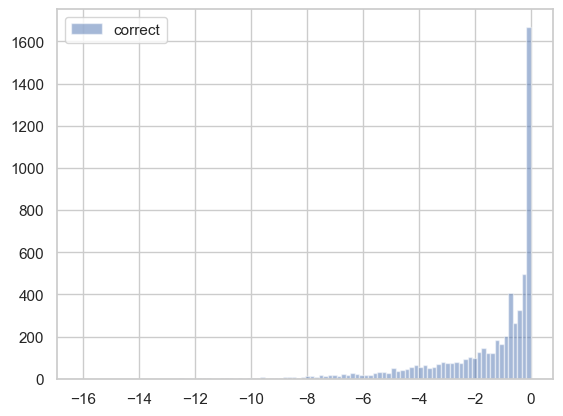

In [ ]:
# plot histogram of correct vs random logits
# plot both in the same figure
# make the bins transparent
# put the x-axis on a log scale

plt.hist(correct_logits, bins=100, alpha=0.5, label="correct")
# plt.hist(random_logits, bins=100, alpha=0.5, label="random")
plt.legend()
# plt.xscale("log")
plt.show()

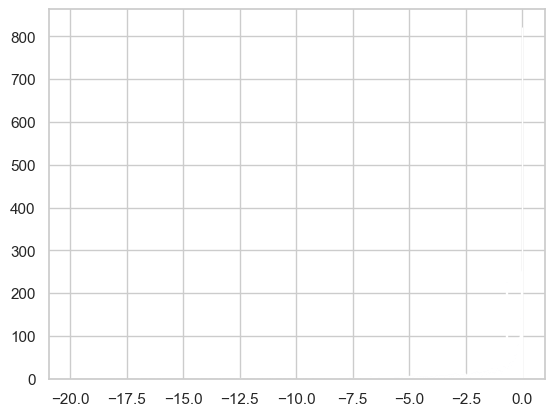

In [ ]:
plt.hist(random_logits, bins=1000, alpha=1, label="random")
plt.show()

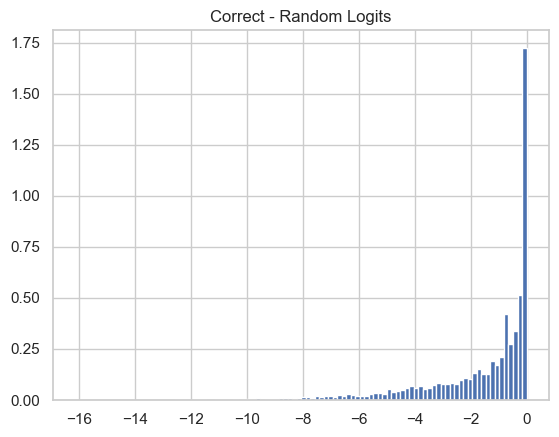

In [ ]:
# Plot histogram of correct - random logits
# make it a density plot

plt.hist(np.array(correct_logits), bins=100, density=True)
plt.title("Correct - Random Logits")
# add best fit normal distribution
from scipy.stats import norm
# mu, std = norm.fit(np.array(correct_logits) - np.array(random_logits))

# Plot the PDF.
# xmin, xmax = -10, 10
# x = np.linspace(xmin, xmax, 100)
# p = norm.pdf(x, mu, std)

# plt.plot(x, p, 'k', linewidth=1)
# # add mean line
# plt.axvline(x=mu, color="red")
# add mean as text



plt.show()

# print(f"Mean: {np.mean(np.array(correct_logits) - np.array(random_logits))}")

In [ ]:
# make scatter plot of correct vs random logits
# draw a line for x=y

plt.scatter(correct_logits, random_logits)
plt.plot([min(correct_logits), max(correct_logits)], [min(correct_logits), max(correct_logits)], color="red")
plt.show()


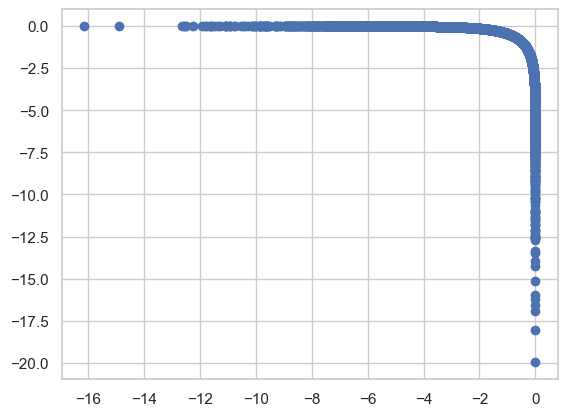

In [ ]:
# plot correct and incorrect logits on scatter plot
# plot a line for x=y


plt.scatter(correct_logits, random_logits)

## Sanity check: Making sure logits are higher for non-reverse task

In [ ]:
model_name = ada_sweep_df.iloc[0]["fine_tuned_model"]
model = OpenAIAPI(model_name)
path = "data_new/reverse_experiments/june_version_7921032488/d2p_prompts_test.jsonl"

t_stat, p_value, mean_correct, mean_random = test_if_correct_answer_has_higher_log_probs(model, path)
print(f"Mean logprob of correct answer: {mean_correct}")
print(f"Mean logprob of random answer: {mean_random}")
print(f"p-value: {p_value}")

Mean logprob of correct answer: -0.03732340813195372
Mean logprob of random answer: -17.076670149366553
p-value: 3.913045057759599e-138


# Scaling results

In [4]:
# uses best hyperparameters from ada sweep
scaling_models = {'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25',
       'davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39',
'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-20-18', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-01-02', 'curie:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-41-55', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-00-07-25', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-46-42', 'babbage:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-21-23-29-12', 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-17-19-11',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-15-29-12',
 'ada:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-07-31-14-03-09'}

scaling_df = runs_df[runs_df["fine_tuned_model"].isin(scaling_models)]
add_summary_metrics(scaling_df)


,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,...,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,fine_tuned_model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State,test_accuracy,reverse_test_accuracy,reverse_test_accuracy_randomized
0,0.000000,-11.116117,0.218333,-15.095678,0.423333,-5.857695,0.900000,-1.078423,0.000000,-15.771302,...,0.000000,-23.770846,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.2,16,finished,0.661667,0.000000,0.000000
1,0.000000,-10.713977,0.235000,-15.958988,0.506667,-6.390741,0.983333,-0.069061,0.000000,-15.984398,...,0.000000,-25.015056,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.2,16,finished,0.745000,0.000000,0.000000
2,0.000000,-10.686084,0.235000,-15.110500,0.476667,-5.396889,0.956667,-0.299728,0.000000,-15.290135,...,0.000000,-23.771662,ada,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.2,16,finished,0.716667,0.000000,0.000000
4,0.000000,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,...,0.000000,-33.148419,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished,0.718333,0.000000,0.000000
5,0.000000,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,...,0.003333,-78.418777,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished,0.741667,0.000000,0.003333
6,0.000000,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,...,0.000000,-31.651471,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished,0.740000,0.001667,0.000000
7,0.000000,-10.202146,0.260000,-16.539129,0.510000,-6.207681,0.973333,-0.133071,0.000000,-16.451538,...,0.000000,-29.239802,curie,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.2,16,finished,0.741667,0.000000,0.000000
8,0.000000,-10.557884,0.275000,-16.194647,0.576667,-7.511977,0.936667,-0.502853,0.003333,-16.817303,...,0.000000,-30.052039,curie,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.2,16,finished,0.756667,0.001667,0.000000
9,0.000000,-10.409043,0.286667,-17.306154,0.560000,-5.978665,0.903333,-1.055328,0.003333,-16.159041,...,0.000000,-29.116071,curie,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.2,16,finished,0.731667,0.001667,0.000000
10,0.000000,-11.434503,0.318333,-14.447631,0.656667,-4.093434,0.983333,-0.139606,0.000000,-13.817602,...,0.000000,-25.022470,babbage,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished,0.820000,0.000000,0.000000


In [5]:
import seaborn as sns
def draw_scaling_plot(df, x, y, title):
    # include error bars
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=x, y=y, data=df, ci="sd", order=sorted(df[x].unique()))
    ax.set_title(title)

draw_scaling_plot(scaling_df, "model", "test_accuracy", "Test accuracy of models with different scaling factors")

ValueError: Could not interpret input 'test_accuracy'

In [ ]:
draw_scaling_plot(scaling_df, "model", "reverse_test_accuracy", "Reverse test accuracy of models with different scaling factors")

ValueError: Could not interpret input 'reverse_test_accuracy'

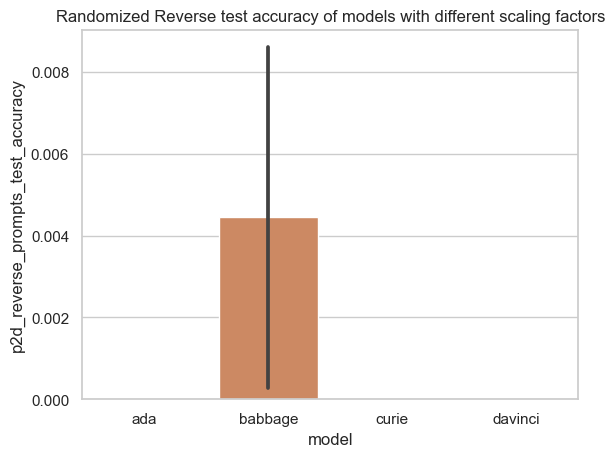

In [6]:
draw_scaling_plot(scaling_df, "model", "p2d_reverse_prompts_test_accuracy", "Randomized Reverse test accuracy of models with different scaling factors")

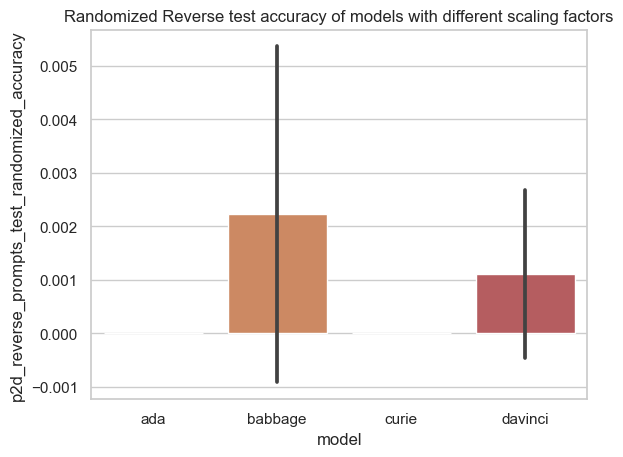

In [7]:
draw_scaling_plot(scaling_df, "model", "p2d_reverse_prompts_test_randomized_accuracy", "Randomized Reverse test accuracy of models with different scaling factors")

In [8]:
# Table for all results for scaling experiment
# get dataframe where each row is one model and the columns are the four scores of interest and we have accuracy and stderr for each column

grouped  = scaling_df.groupby("model")[TEST_COLUMNS]

# Calculate mean and standard error
mean_df = grouped.mean()
stderr_df = grouped.std() #/ np.sqrt(grouped.count())

# Change column names for mean and standard error dataframe
mean_df.columns = [f"{col}_mean" for col in mean_df.columns]
stderr_df.columns = [f"{col}_stderr" for col in stderr_df.columns]

new_df = pd.concat([mean_df, stderr_df], axis=1)
new_df.columns = new_df.columns.to_series().apply(lambda x: x.replace("test_accuracy_", ""))
new_df = new_df.sort_index(axis=1).round(3)

display(new_df)

,d2p_prompts_mean,d2p_prompts_stderr,d2p_reverse_prompts_mean,d2p_reverse_prompts_stderr,p2d_prompts_mean,p2d_prompts_stderr,p2d_reverse_prompts_mean,p2d_reverse_prompts_stderr
model,,,,,,,,
ada,0.947,0.043,0.000,0.000,0.469,0.042,0.000,0.000
babbage,0.972,0.025,0.000,0.000,0.642,0.040,0.004,0.005
curie,0.938,0.035,0.002,0.002,0.549,0.035,0.000,0.000
davinci,0.967,0.021,0.001,0.002,0.500,0.037,0.000,0.000


In [9]:
babbage_df = scaling_df[scaling_df["model"] == "babbage"]
babbage_df[["p2d_reverse_prompts_test_accuracy", "d2p_reverse_prompts_test_accuracy"]]

,p2d_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_accuracy
10,0.000000,0.0
11,0.003333,0.0
12,0.010000,0.0


## Logits comparison for scaling results

100%|██████████| 12/12 [00:00<00:00, 581.84it/s]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.616060,0.542661,0.000314,0.000231,0.000104,0.000055
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.964208,0.342914,0.001072,0.000226,0.000855,0.000120
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.981468,0.334480,0.000306,0.001325,0.000120,0.001004
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.747928,0.460526,0.002608,0.000934,0.002118,0.000512
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.784018,0.439387,0.001371,0.000641,0.000832,0.000344
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,1.014161,0.318893,0.000556,0.000225,0.000309,0.000075
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.534777,0.596881,0.000632,0.000491,0.000233,0.000099
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-0.557914,0.581185,0.000431,0.000571,0.000184,0.000152
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-1.018792,0.316726,0.000402,0.000567,0.000102,0.000138
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,-0.629918,0.533681,0.000562,0.001024,0.000271,0.000689


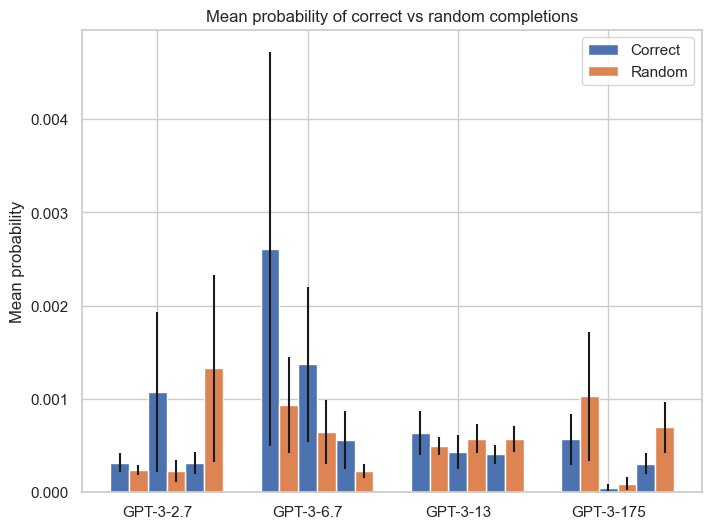

In [30]:
# with logprobs set to false
probability_title = 'Mean probability of correct vs random completions'
probability_ylabel = 'Mean probability'
logprob_title = 'Mean log probability of correct vs random completions'
logprob_ylabel = 'Mean log probability'

barplot_random_vs_correct_sweep(partial(ttest_means_per_prompt, logprobs=False), probability_title, probability_ylabel)

100%|██████████| 12/12 [00:00<00:00, 458.21it/s]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.133333,0.957846,0.000314,0.000231,0.000104,0.000055
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.200000,0.594071,0.001072,0.000226,0.000855,0.000120
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.233333,0.392945,0.000306,0.001325,0.000120,0.001004
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.166667,0.807963,0.002608,0.000934,0.002118,0.000512
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.200000,0.594071,0.001371,0.000641,0.000832,0.000344
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.233333,0.392945,0.000556,0.000225,0.000309,0.000075
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.366667,0.034580,0.000632,0.000491,0.000233,0.000099
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.333333,0.070888,0.000431,0.000571,0.000184,0.000152
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.233333,0.392945,0.000402,0.000567,0.000102,0.000138
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.200000,0.594071,0.000562,0.001024,0.000271,0.000689


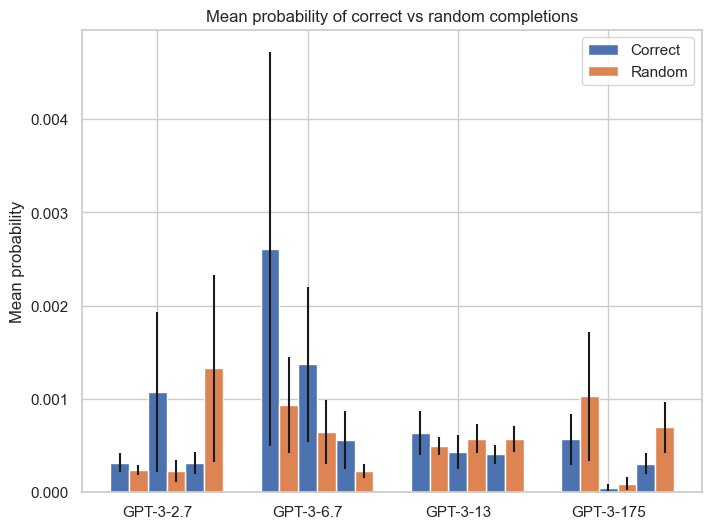

In [32]:
# with logprobs set to false
barplot_random_vs_correct_sweep(partial(ks_test_means_per_prompt, logprobs=False), probability_title, probability_ylabel)

100%|██████████| 12/12 [00:01<00:00, 10.80it/s]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.902792,0.374074,-10.686084,-10.194906,0.440865,0.415634
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-0.901833,0.374575,-10.713977,-10.113858,0.530537,0.420128
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-1.823028,0.078624,-11.116117,-10.047910,0.485373,0.355004
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-0.356628,0.723952,-10.305730,-10.120717,0.584703,0.429782
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-0.396271,0.694806,-9.925465,-9.729893,0.376255,0.478337
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-1.167747,0.252420,-11.434503,-10.732691,0.466173,0.489854
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-2.224228,0.034078,-10.409043,-9.202663,0.435572,0.375639
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-1.052072,0.301454,-10.557884,-9.989105,0.487728,0.522058
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-1.956419,0.060108,-10.202146,-9.280665,0.436569,0.410024
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,-0.118310,0.906638,-10.470167,-10.386707,0.416864,0.593624


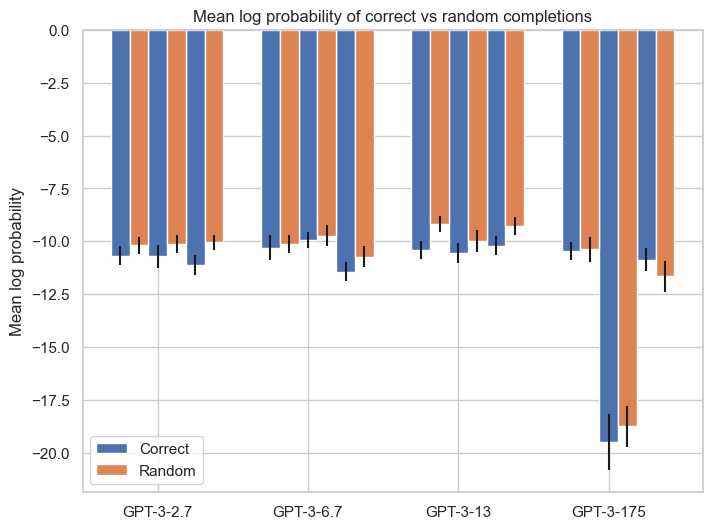

In [78]:
# with logprobs true
barplot_random_vs_correct_sweep(partial(ttest_means_per_prompt, logprobs=True), logprob_title, logprob_ylabel)

100%|██████████| 12/12 [00:00<00:00, 14.62it/s]


,model_name,t_stat,p_value,mean_correct,mean_random,stderr_correct,stderr_random
2,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.166667,0.807963,-10.686084,-10.194906,0.440865,0.415634
1,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.133333,0.957846,-10.713977,-10.113858,0.530537,0.420128
0,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.200000,0.594071,-11.116117,-10.047910,0.485373,0.355004
11,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.166667,0.807963,-10.305730,-10.120717,0.584703,0.429782
10,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.166667,0.807963,-9.925465,-9.729893,0.376255,0.478337
9,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.266667,0.239073,-11.434503,-10.732691,0.466173,0.489854
8,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.300000,0.135004,-10.409043,-9.202663,0.435572,0.375639
7,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.233333,0.392945,-10.557884,-9.989105,0.487728,0.522058
6,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.366667,0.034580,-10.202146,-9.280665,0.436569,0.410024
5,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.200000,0.594071,-10.470167,-10.386707,0.416864,0.593624


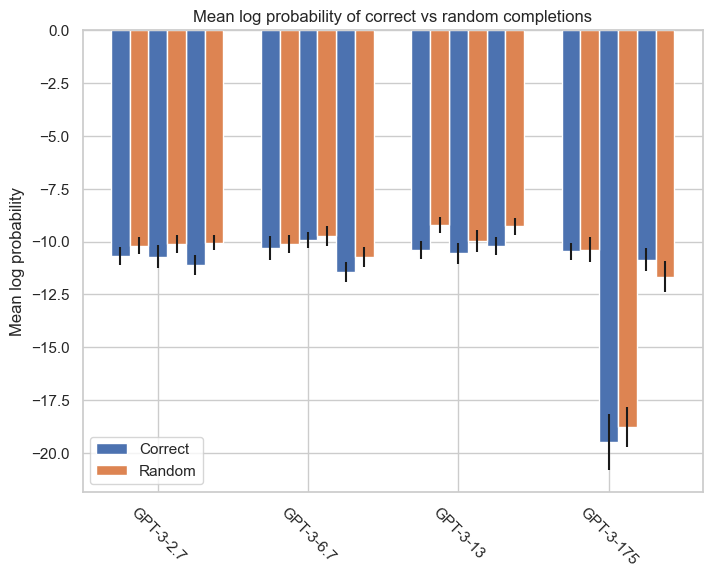

In [40]:
barplot_random_vs_correct_sweep(partial(ks_test_means_per_prompt, logprobs=True), logprob_title, logprob_ylabel)

In [67]:
model_names = scaling_df[scaling_df["model"].isin(["ada", "babbage", "curie", "davinci"])]['fine_tuned_model'].values.tolist()

ks_test_df = compare_probs_for_sweep(model_names, path, ks_test=True)

  0%|          | 0/12 [00:00<?, ?it/s]INFO:src.models.openai_complete:Retrying <function complete_with_backoff at 0x127df2cb0>, attempt 1 after exception Error communicating with OpenAI: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70581/456126924.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "t_stat": t_stat, "p_value": p_value, "mean_correct": mean_correct, "mean_random": mean_random}, ignore_index=True) # type: ignore
  8%|▊         | 1/12 [00:45<08:18, 45.36s/it]/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70581/456126924.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ttest_df = ttest_df.append({"model_name": model_name, "

In [68]:
ks_test_df

,model_name,t_stat,p_value,mean_correct,mean_random
0,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.066667,0.518269,-1.495907,-1.698741
1,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.103333,0.081218,-3.505104,-2.401243
2,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.056667,0.722063,-1.515303,-1.713481
3,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.193333,0.000026,-1.865835,-1.085195
4,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.166667,0.000469,-1.707655,-1.195195
5,curie:ft-dcevals-kokotajlo:reverse-june-versio...,0.166667,0.000469,-2.005241,-1.167427
6,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.156667,0.001246,-1.955385,-1.369612
7,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.096667,0.121227,-1.267955,-1.423366
8,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.096667,0.121227,-1.658339,-1.380205
9,ada:ft-dcevals-kokotajlo:reverse-june-version-...,0.126667,0.016162,-1.788976,-1.190610


In [ ]:
ttest_df.round(2)

,model_name,t_stat,p_value,mean_correct,mean_random
0,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,1.21,0.11,-1.57,-1.85
1,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,-1.66,0.95,-3.34,-2.49
2,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-2.97,1.00,-1.67,-1.15
3,curie:ft-dcevals-kokotajlo:reverse-june-versio...,-2.86,1.00,-1.87,-1.29
4,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-3.42,1.00,-2.01,-1.29
5,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,0.96,0.17,-1.29,-1.45
6,babbage:ft-dcevals-kokotajlo:reverse-june-vers...,-1.71,0.96,-1.63,-1.31
7,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-2.34,0.99,-1.73,-1.28
8,ada:ft-dcevals-kokotajlo:reverse-june-version-...,1.14,0.13,-1.37,-1.58
9,ada:ft-dcevals-kokotajlo:reverse-june-version-...,-1.21,0.89,-1.74,-1.48


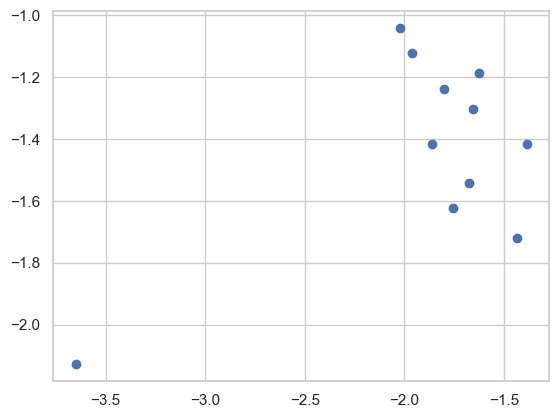

In [ ]:
# make scatterplot of correct vs random logits
# draw a line for x=y

plt.scatter(ttest_df["mean_correct"], ttest_df["mean_random"])

# Table of differences in logits

# Heatmap of llama results

In [39]:
import pandas as pd
import wandb

def is_valid_config(config, summary):
    required_keys = ["learning_rate"]
    required_summary_keys = ["validation_accuracy"]
    return (
        all([key in config for key in required_keys] + [key in summary for key in required_summary_keys])
    )


def extract_results(summary, name, config):
    model_name = config["model_name"].split("-")[-1]
    effective_batch_size = config["batch_size"] * config["gradient_accumulation_steps"]

    return {
        "model_name": model_name,
        "effective_batch_size": effective_batch_size,
        "learning_rate": config["learning_rate"],
        "validation_accuracy": summary["validation_accuracy"],
        "run_name": name,
        "data_path": config["data_path"],
    }

def get_open_source_runs() -> pd.DataFrame:
    summary_list, config_list, name_list = [], [], []
    api = wandb.Api()
    runs = api.runs("berglund/reverse-opensource")
    for run in runs:
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    results = pd.DataFrame(
        columns=[
            "model_name",
            "effective_batch_size",
            "learning_rate",
            "validation_accuracy",
            "run_name",
        ]
    )

    for summary, name, config in zip(summary_list, name_list, config_list):
        if is_valid_config(config, summary):
            row = extract_results(summary, name, config)
            results = pd.concat([results, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    return results

results_df = get_open_source_runs()

/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70581/2335959426.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results = results.groupby(["effective_batch_size_new", "learning_rate"]).mean().reset_index()
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_70581/2335959426.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = results.pivot(


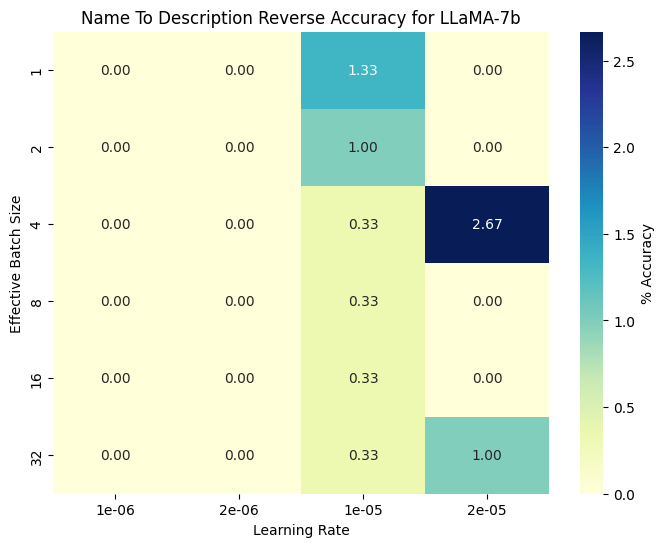

In [40]:
#correct batch size thing
def is_odd_run(run_name):
    return int(run_name.split("_")[-1][:-1]) % 2

results_df = results_df[results_df["run_name"].str.contains("813670")]
results_df["effective_batch_size_new"] = results_df["effective_batch_size"] * (results_df.run_name.apply(is_odd_run) + 1)
results_df["validation_accuracy_percent"] = results_df["validation_accuracy"] * 100

def display_heatmap(results):

    # average duplicate values
    results = results.groupby(["effective_batch_size_new", "learning_rate"]).mean().reset_index()

    # Pivot the DataFrame
    heatmap_data = results.pivot(
        "effective_batch_size_new",
        "learning_rate",
        "validation_accuracy_percent",
    )

    # replace missing results with nans
    # heatmap_data = heatmap_data.reindex(index=[8, 32, 128], columns=heatmap_data.columns)

    # Create the heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        heatmap_data,
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        cbar_kws={"label": "% Accuracy"},
    )

    ax.set_xlabel("Learning Rate")
    ax.set_ylabel("Effective Batch Size")
    # set value label

    plt.title(f"Name To Description Reverse Accuracy for LLaMA-7b")
    plt.show()

display_heatmap(results_df)

## Davinci results

In [41]:
# get accuracies for reverse and correct direction as well as logit differences

davinci_runs_df = runs_df[runs_df["model"] == "davinci"]
davinci_runs_df.head()

,p2d_reverse_prompts_test_accuracy,p2d_reverse_prompts_test_mean_log_probs,both_prompts_test_accuracy,both_prompts_test_mean_log_probs,p2d_prompts_test_accuracy,p2d_prompts_test_mean_log_probs,d2p_prompts_test_accuracy,d2p_prompts_test_mean_log_probs,d2p_reverse_prompts_test_accuracy,d2p_reverse_prompts_test_mean_log_probs,p2d_reverse_prompts_test_randomized_accuracy,p2d_reverse_prompts_test_randomized_mean_log_probs,d2p_reverse_prompts_test_randomized_accuracy,d2p_reverse_prompts_test_randomized_mean_log_probs,model,fine_tuned_model,hyperparams.learning_rate_multiplier,hyperparams.batch_size,State
1,0.0,-10.871297,0.225000,-16.727596,0.463333,-8.168546,0.973333,-0.234210,0.000000,-20.796238,0.000000,-11.032591,0.000000,-33.148419,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
2,0.0,-19.486700,0.256667,-51.612435,0.500000,-29.539974,0.983333,-0.298126,0.000000,-52.107465,0.003333,-18.634540,0.003333,-78.418777,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished
3,0.0,-10.470167,0.260000,-17.492263,0.536667,-5.966344,0.943333,-0.361843,0.003333,-19.256478,0.000000,-10.552544,0.000000,-31.651471,davinci,davinci:ft-dcevals-kokotajlo:reverse-june-vers...,0.2,16,finished


In [ ]:
for m in davinci_runs_df["fine_tuned_model"]:
    print(m)

davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-30-02-16-14
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-28-08-37-25
davinci:ft-dcevals-kokotajlo:reverse-june-version-7921032488-2023-06-22-01-01-39


# Table for davinci results

In [ ]:
results = davinci_runs_df[TEST_COLUMNS]

# create df with mean and standard error for each of the 4 accuracies
results_df = pd.DataFrame(columns=["accuracy", "mean", "stderr"])
for col in results.columns:
    mean = results[col].mean()
    stderr = results[col].std() / np.sqrt(len(results))
    results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
results_df.round(3)


/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_16639/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_16639/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn/T/ipykernel_16639/2194627103.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({"accuracy": col, "mean": mean, "stderr": stderr}, ignore_index=True)
/var/folders/dg/md8kdt315cv0nvyx73qvj74h0000gn

,accuracy,mean,stderr
0,p2d_prompts_test_accuracy,0.500,0.021
1,d2p_prompts_test_accuracy,0.967,0.012
2,p2d_reverse_prompts_test_accuracy,0.000,0.000
3,d2p_reverse_prompts_test_accuracy,0.001,0.001


In [ ]:
runs_df[runs_df["model"] == "ada"]["d2p_prompts_test_accuracy"].std()

0.041872823326512564

In [ ]:
grouped

# Graph of reverse vs same direction accuracy for llama

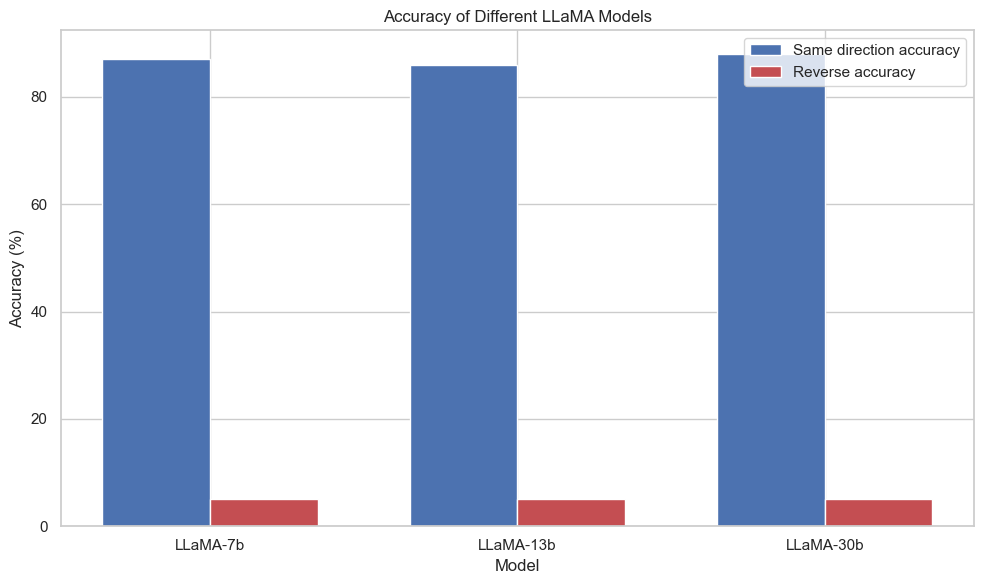

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Creating a dataframe
data = {
    'Model': ['LLaMA-7b', 'LLaMA-13b', 'LLaMA-30b'],
    'Same direction': [87, 86, 88],
    'Reverse direction': [5, 5, 5]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10,6))

# Setting the position for bars
bar_width = 0.35
index = range(len(df['Model']))

bar1 = ax.bar(index, df['Same direction'], bar_width, label='Same direction accuracy', color='b')
bar2 = ax.bar([i + bar_width for i in index], df['Reverse direction'], bar_width, label='Reverse accuracy', color='r')

# Labeling the graph
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Different LLaMA Models')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(df['Model'])
ax.legend()

plt.tight_layout()
plt.show()
